In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import importlib
import src.train_functions
import src.utils
import src.models

importlib.reload(src.train_functions)
importlib.reload(src.utils)
importlib.reload(src.models)

from src.train_functions import train_step, val_step, test_step
from src.utils import load_data, set_seed, save_model,load_model, parameters_to_double
from src.models import LogisticModel

In [11]:
df = pd.read_csv('data/Loan_default_2.csv')
df

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


In [20]:
df = df.drop(['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'], axis=1).dropna()

In [29]:
# df = df.drop(['year'], axis=1)
df.to_csv('data/Loan_default_2_clean.csv', index=False)

In [25]:
df.select_dtypes(include=[np.number])

,ID,year,loan_amount,term,property_value,income,Credit_Score,LTV,Status,dtir1
0,24890,2019,116500,360.0,118000.0,1740.0,758,98.728814,1,45.0
2,24892,2019,406500,360.0,508000.0,9480.0,834,80.019685,0,46.0
3,24893,2019,456500,360.0,658000.0,11880.0,587,69.376900,0,42.0
4,24894,2019,696500,360.0,758000.0,10440.0,602,91.886544,0,39.0
5,24895,2019,706500,360.0,1008000.0,10080.0,864,70.089286,0,40.0
...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,436500,180.0,608000.0,7860.0,659,71.792763,0,48.0
148666,173556,2019,586500,360.0,788000.0,7140.0,569,74.428934,0,15.0
148667,173557,2019,446500,180.0,728000.0,6900.0,702,61.332418,0,49.0
148668,173558,2019,196500,180.0,278000.0,7140.0,737,70.683453,0,29.0


# Data processing

In [5]:
df = df.drop(['ID'], axis=1)
# df = df.drop(['SK_ID_CURR'], axis=1)

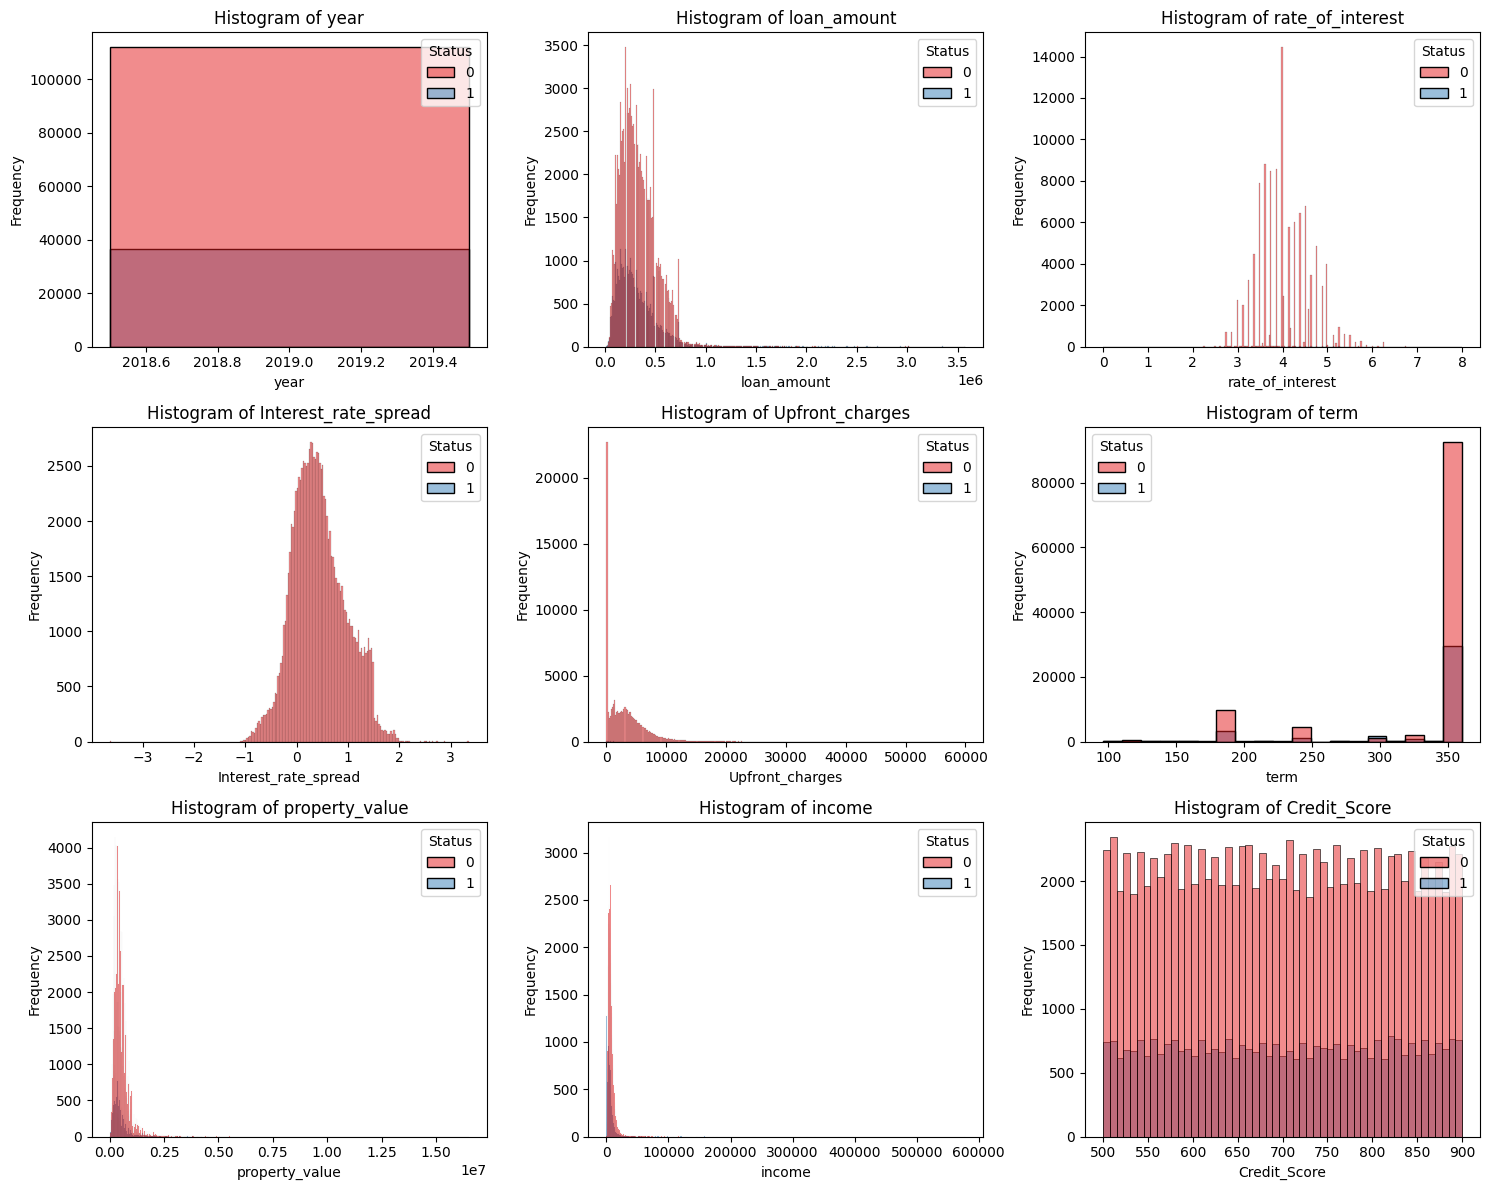

In [6]:

target_column = df.loc[:, df.nunique() == 2].select_dtypes(include=[int]).columns[-1]

# Plotting the histogram with seaborn
columns_to_plot = df.select_dtypes(include=np.number).columns.drop(target_column)[:9]

# Create subplots
num_columns = len(columns_to_plot)
plt.figure(figsize=(15, 12))

# Loop over the columns and create a histogram for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid (3x3) according to the number of columns
    sns.histplot(data=df, x=column, hue=target_column, multiple='layer', palette='Set1', kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [123]:
target_column = df.loc[:, df.nunique() == 2].select_dtypes(include=[int]).columns[0]


In [124]:
# df

In [9]:
# study the correlation between the EXT_SOURCE_3 and the TARGET
# sns.histplot(data=df, x='EXT_SOURCE_1', hue='TARGET', multiple='layer', palette='Set1', kde=False)

In [10]:

# df[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']] = df[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(0)


# df['HOUSETYPE_MODE'].value_counts()#.apply(lambda x: x.split()[0]).value_counts()

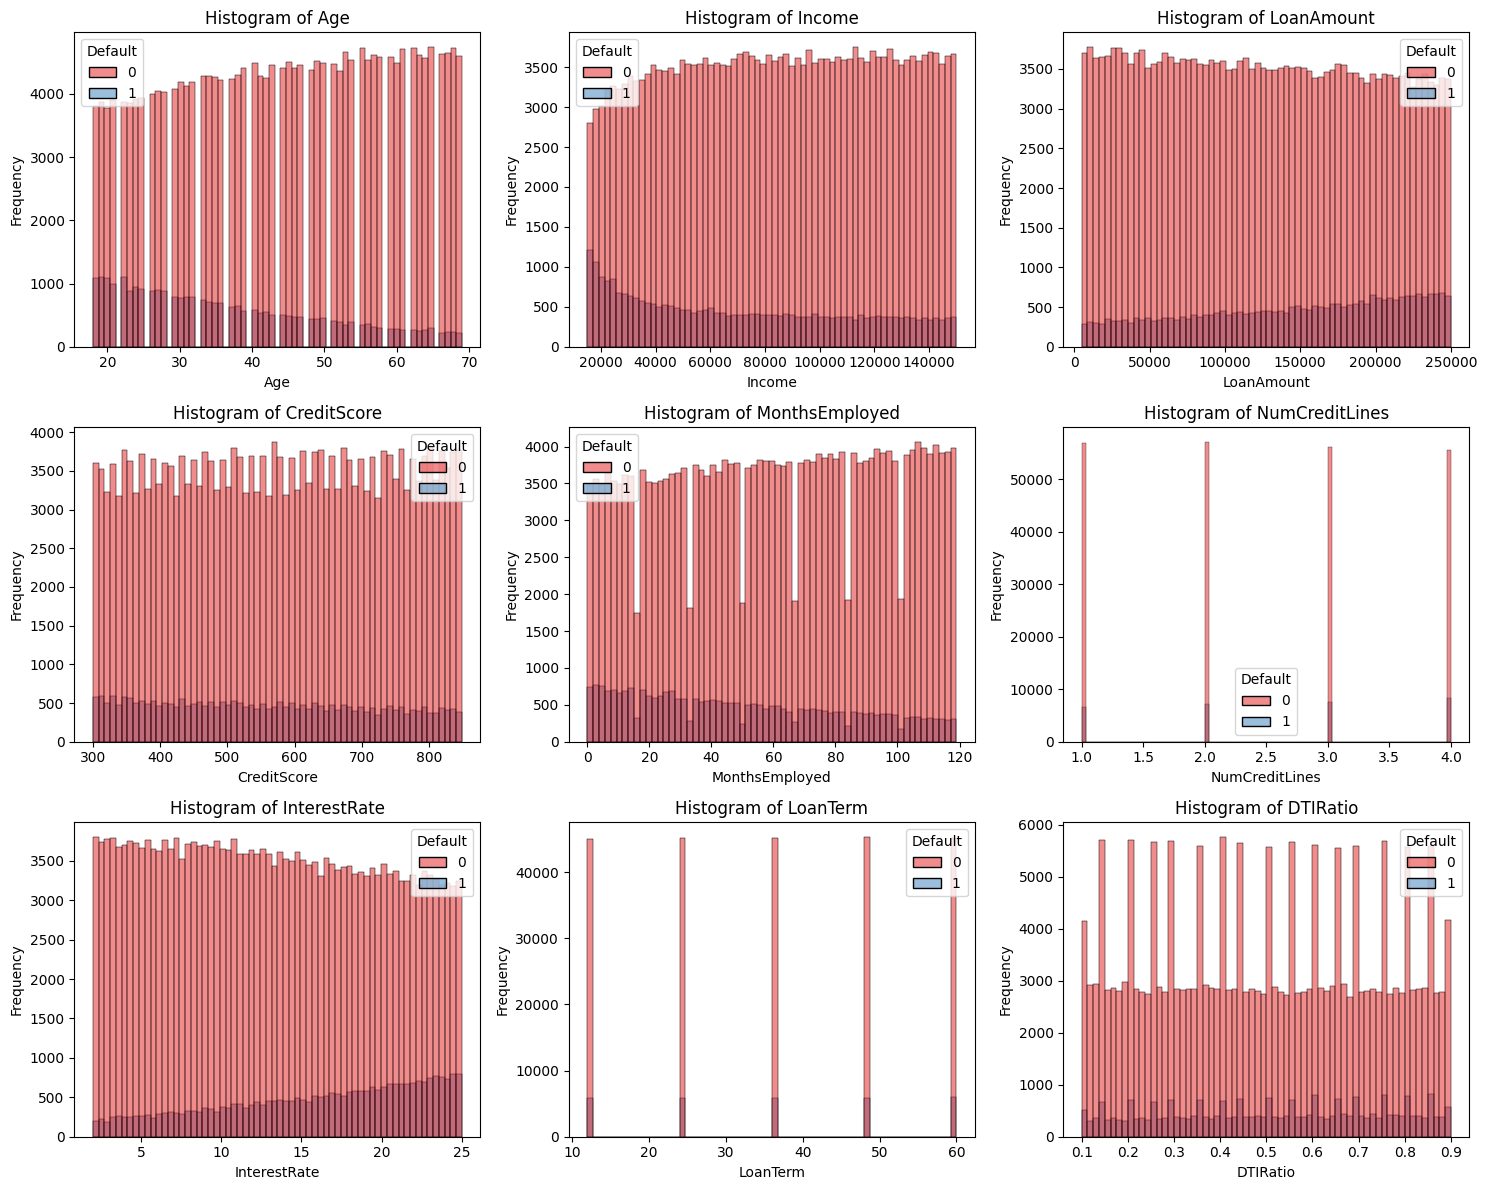

In [11]:

target_column = df.loc[:, df.nunique() == 2].select_dtypes(include=[int]).columns[0]

# Plotting the histogram with seaborn
columns_to_plot = df.select_dtypes(include=np.number).columns.drop(target_column)[:9]

# Create subplots
num_columns = len(columns_to_plot)
plt.figure(figsize=(15, 12))

# Loop over the columns and create a histogram for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid (3x3) according to the number of columns
    sns.histplot(data=df, x=column, hue=target_column, multiple='layer', palette='Set1', kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [12]:
target_column = df.loc[:, df.nunique() == 2].select_dtypes(include=[int]).columns[0]


In [13]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_columns = df.select_dtypes(exclude=['object']).columns[: -1]  # Exclude the target column
df[num_columns] = scaler.fit_transform(df[num_columns])
df.head()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,0.833990,0.089693,-1.086833,-0.341492,0.590533,1.341937,0.261771,-0.001526,-0.260753,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,1.701221,-0.823021,-0.044309,-0.731666,-1.285731,-1.343791,-1.308350,1.412793,0.778585,Master's,Full-time,Married,No,No,Other,Yes,0
2,0.166888,0.043854,0.022715,-0.775718,-0.968209,0.446694,1.156831,-0.708685,-0.823728,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,-0.767053,-1.303452,-1.168538,1.061875,-1.718715,0.446694,-0.967805,-0.708685,-1.170174,High School,Full-time,Married,No,No,Business,No,0
4,1.100830,-1.592855,-1.671921,0.369631,-1.487790,1.341937,-1.052188,0.705634,0.995114,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [126]:
quality_map = {'Yes': True, 'No': False}

df['HasMortgage'] = df['HasMortgage'].map(quality_map)
df['HasCoSigner'] = df['HasCoSigner'].map(quality_map)
df['HasDependents'] = df['HasDependents'].map(quality_map)

In [127]:
# One-hot encoding
obj_columns = df.select_dtypes(include=['object']).columns
obj_columns


Index(['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'], dtype='object')

In [128]:
df_encoded = pd.get_dummies(df, columns=obj_columns)
df_encoded.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,HasMortgage,...,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,0.833990,0.089693,-1.086833,-0.341492,0.590533,1.341937,0.261771,-0.001526,-0.260753,True,...,False,False,True,False,False,False,False,False,False,True
1,1.701221,-0.823021,-0.044309,-0.731666,-1.285731,-1.343791,-1.308350,1.412793,0.778585,False,...,False,False,False,True,False,False,False,False,False,True
2,0.166888,0.043854,0.022715,-0.775718,-0.968209,0.446694,1.156831,-0.708685,-0.823728,True,...,False,True,True,False,False,True,False,False,False,False
3,-0.767053,-1.303452,-1.168538,1.061875,-1.718715,0.446694,-0.967805,-0.708685,-1.170174,False,...,False,False,False,True,False,False,True,False,False,False
4,1.100830,-1.592855,-1.671921,0.369631,-1.487790,1.341937,-1.052188,0.705634,0.995114,False,...,False,True,True,False,False,True,False,False,False,False


In [129]:
df_encoded.select_dtypes(include=[object]).columns

Index([], dtype='object')

In [130]:
# specify the order of the categories
object_cols = df_encoded.select_dtypes(include=[bool, object]).columns

df_encoded[object_cols] = df_encoded[object_cols].astype(int)




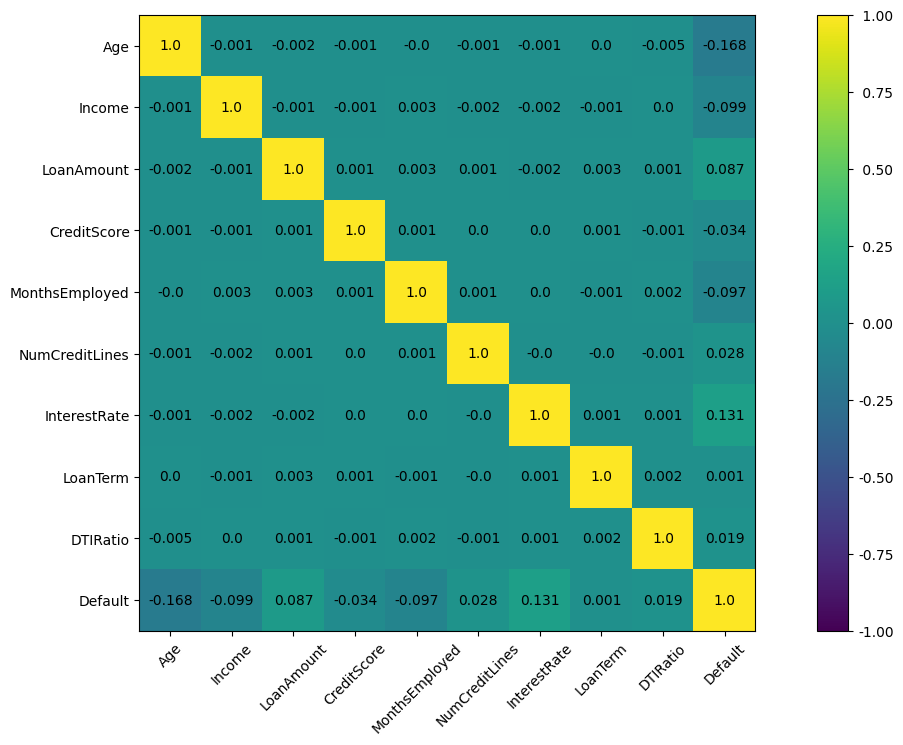

In [131]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=[i for i in range(len(corr_matrix))], ticklabels=corr_matrix.columns)
ax.yaxis.set(ticks=[i for i in range(len(corr_matrix))], ticklabels=corr_matrix.columns)
# ax.set_ylim(2.5, -0.5)
for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        ax.text(j, i, round(corr_matrix[col1][col2], 3), ha='center', va='center',
                color='black')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.xticks(rotation=45)
plt.show()

In [134]:
from src.utils import LoanDataset
from torch.utils.data import random_split

def load_data(data: pd.DataFrame, batch_size: int):

    dataset = LoanDataset(data, target_column)

    train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2])


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

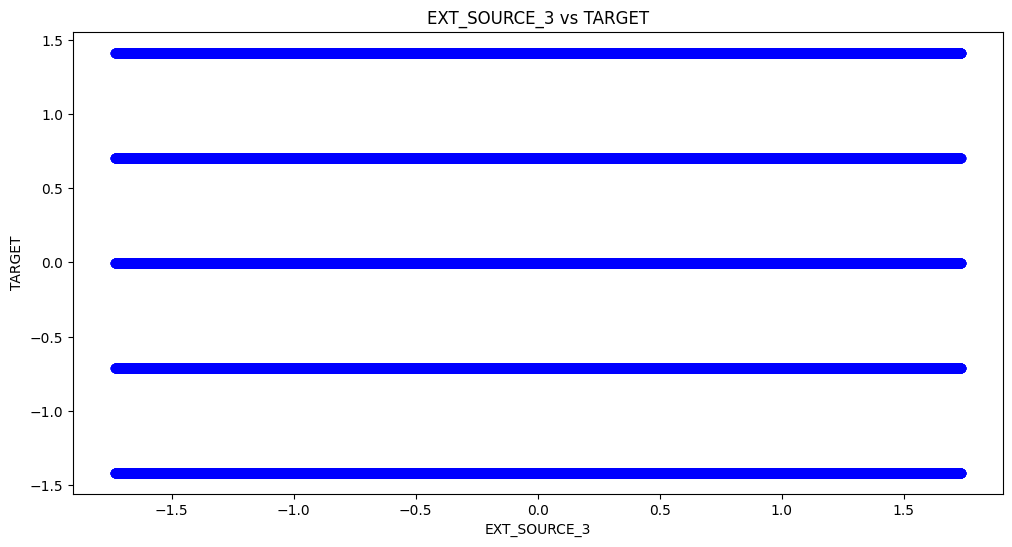

In [21]:
# Scatter plot, interest rate against loan term
plt.figure(figsize=(12, 6))
plt.scatter(df['InterestRate'], df['LoanTerm'], color='blue', alpha=0.5)
plt.title('EXT_SOURCE_3 vs TARGET')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('TARGET')
plt.show()


There is no clear correlation between any of the variables

In [134]:
from src.utils import LoanDataset
from torch.utils.data import random_split

def load_data(data: pd.DataFrame, batch_size: int):

    dataset = LoanDataset(data, target_column)

    train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2])


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

In [147]:
set_seed(42)

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


"""
This function is the main program for training.
"""

# probar con más epochs los mejores 3 modelos

# hyperparameters
epochs: int = 30
lr: float = 4e-4
batch_size: int = 1024
hidden_sizes: tuple[int, ...] = [128, 64] #(128, 64)

# empty nohup file
open("nohup.out", "w").close()

# load data
train_data: DataLoader
val_data: DataLoader
train_data, val_data, test_data = load_data(df_encoded, batch_size=batch_size)

# define name and writer
name: str = f"model_logistic_lr_{lr}_bs_{batch_size}_hs_{hidden_sizes}_{epochs}"
writer: SummaryWriter = SummaryWriter(f"runs/{name}")

# define model
inputs: torch.Tensor = next(iter(train_data))[0]
model: torch.nn.Module = LogisticModel(
    inputs.shape[1], hidden_sizes,
).to(device)
parameters_to_double(model)

# Compute class frequencies
# class_weights = torch.tensor(list(df[target_column].value_counts(normalize=True))[::-1]).to(device)
class_weights = torch.tensor([0.2, 1.8]).to(device)


# define loss and optimizer
loss: torch.nn.Module = torch.nn.CrossEntropyLoss(weight=class_weights)
# loss: torch.nn.Module = torch.nn.CrossEntropyLoss()
optimizer: torch.optim.Optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# train loop
for epoch in tqdm(range(epochs)):
    # call train step
    train_step(model, train_data, loss, optimizer, writer, epoch, device)

    # call val step
    val_step(model, val_data, loss, writer, epoch, device)

# save model
save_model(model, name)





  3%|▎         | 1/30 [00:01<00:31,  1.09s/it]

Epoch 0 - train accuracy: 0.15413957634228187
Epoch 0 - val accuracy: 0.15188536352040816
Epoch 1 - train accuracy: 0.14669410654362416


  7%|▋         | 2/30 [00:02<00:30,  1.09s/it]

Epoch 1 - val accuracy: 0.14490991709183673


 10%|█         | 3/30 [00:03<00:31,  1.16s/it]

Epoch 2 - train accuracy: 0.14091338087248323
Epoch 2 - val accuracy: 0.14012675382653061


 13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]

Epoch 3 - train accuracy: 0.1365286807885906
Epoch 3 - val accuracy: 0.13651945153061223
Epoch 4 - train accuracy: 0.13342858640939598


 17%|█▋        | 5/30 [00:05<00:26,  1.06s/it]

Epoch 4 - val accuracy: 0.13323102678571427
Epoch 5 - train accuracy: 0.13078072567114093


 20%|██        | 6/30 [00:06<00:24,  1.02s/it]

Epoch 5 - val accuracy: 0.13139748086734693


 23%|██▎       | 7/30 [00:07<00:22,  1.01it/s]

Epoch 6 - train accuracy: 0.12932571308724833
Epoch 6 - val accuracy: 0.12936463647959184


 27%|██▋       | 8/30 [00:08<00:21,  1.02it/s]

Epoch 7 - train accuracy: 0.1277134018456376
Epoch 7 - val accuracy: 0.12745137117346939
Epoch 8 - train accuracy: 0.12642224203020133


 30%|███       | 9/30 [00:09<00:20,  1.00it/s]

Epoch 8 - val accuracy: 0.12693319515306123


 33%|███▎      | 10/30 [00:10<00:19,  1.02it/s]

Epoch 9 - train accuracy: 0.12600277894295303
Epoch 9 - val accuracy: 0.12601642219387754


 37%|███▋      | 11/30 [00:11<00:18,  1.04it/s]

Epoch 10 - train accuracy: 0.12498689177852348
Epoch 10 - val accuracy: 0.1253985969387755
Epoch 11 - train accuracy: 0.1244756711409396


 40%|████      | 12/30 [00:12<00:17,  1.02it/s]

Epoch 11 - val accuracy: 0.12484056122448979


 43%|████▎     | 13/30 [00:13<00:16,  1.03it/s]

Epoch 12 - train accuracy: 0.12411519505033557
Epoch 12 - val accuracy: 0.12470105229591837


 47%|████▋     | 14/30 [00:14<00:16,  1.05s/it]

Epoch 13 - train accuracy: 0.12401032927852348
Epoch 13 - val accuracy: 0.12422273596938775


 50%|█████     | 15/30 [00:15<00:15,  1.02s/it]

Epoch 14 - train accuracy: 0.12400377516778524
Epoch 14 - val accuracy: 0.12392378826530612
Epoch 15 - train accuracy: 0.12401032927852348


 53%|█████▎    | 16/30 [00:16<00:14,  1.04s/it]

Epoch 15 - val accuracy: 0.12414301658163265


 57%|█████▋    | 17/30 [00:17<00:13,  1.02s/it]

Epoch 16 - train accuracy: 0.12396445050335571
Epoch 16 - val accuracy: 0.12462133290816327


 60%|██████    | 18/30 [00:18<00:12,  1.00s/it]

Epoch 17 - train accuracy: 0.12425938548657718
Epoch 17 - val accuracy: 0.12456154336734694
Epoch 18 - train accuracy: 0.12464607802013423


 63%|██████▎   | 19/30 [00:19<00:11,  1.01s/it]

Epoch 18 - val accuracy: 0.12517936862244897


 67%|██████▋   | 20/30 [00:20<00:09,  1.02it/s]

Epoch 19 - train accuracy: 0.12511141988255034
Epoch 19 - val accuracy: 0.12577726403061223


 70%|███████   | 21/30 [00:21<00:08,  1.02it/s]

Epoch 20 - train accuracy: 0.12567507340604026
Epoch 20 - val accuracy: 0.1263153698979592
Epoch 21 - train accuracy: 0.12633703859060402


 73%|███████▎  | 22/30 [00:22<00:08,  1.01s/it]

Epoch 21 - val accuracy: 0.12693319515306123
Epoch 22 - train accuracy: 0.12724150587248323


 77%|███████▋  | 23/30 [00:23<00:06,  1.01it/s]

Epoch 22 - val accuracy: 0.1280094068877551


 80%|████████  | 24/30 [00:24<00:05,  1.01it/s]

Epoch 23 - train accuracy: 0.12832948825503357
Epoch 23 - val accuracy: 0.12974330357142858


 83%|████████▎ | 25/30 [00:25<00:04,  1.03it/s]

Epoch 24 - train accuracy: 0.12980416317114093
Epoch 24 - val accuracy: 0.1309191645408163
Epoch 25 - train accuracy: 0.13168519295302014


 87%|████████▋ | 26/30 [00:26<00:04,  1.01s/it]

Epoch 25 - val accuracy: 0.1327527104591837


 90%|█████████ | 27/30 [00:27<00:02,  1.02it/s]

Epoch 26 - train accuracy: 0.13300912332214765
Epoch 26 - val accuracy: 0.1345264668367347


 93%|█████████▎| 28/30 [00:28<00:01,  1.02it/s]

Epoch 27 - train accuracy: 0.13487704488255034
Epoch 27 - val accuracy: 0.13681839923469388
Epoch 28 - train accuracy: 0.1377674077181208


 97%|█████████▋| 29/30 [00:29<00:01,  1.00s/it]

Epoch 28 - val accuracy: 0.1394889987244898


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]

Epoch 29 - train accuracy: 0.14057256711409397
Epoch 29 - val accuracy: 0.1425183354591837


In [148]:
# pensar undersampling y luego utilizar como validación

In [149]:
# # importing needful librariries 
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.metrics import accuracy_score, classification_report

# # split the data
# X = df_encoded.drop('Default', axis=1)
# y = df_encoded['Default']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # scale the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # define the model
# model = Sequential()
# model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit the model
# model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# # predict
# y_pred = model.predict(X_test)

In [150]:
# TODO: outliers
# TODO: automatizar proceso de los .py
# TODO: generalizar el batch size y todos los parametros
# TODO: analisis exploratorio de los resultados (F1 score y matriz)
# TODO: probar más capas (generalizarlo)
# TODO: añadir semilla al random_split

In [152]:

def main(name: str) -> float:
    """
    This function is the main program for the testing.
    """


    # define model
    model = load_model(f"{name}").to(device)

    # call test step and evaluate accuracy
    accuracy, f1, conf_matrix = test_step(model, test_data, device)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    return accuracy, f1, conf_matrix


if __name__ == "__main__":
    main(name)


Accuracy: 0.14293686224489796
F1 Score: 0.13619131997637346
Confusion Matrix:
[[ 1369 42954]
 [   50  5803]]
